In [1]:
import sys
sys.path.insert(0,'../environments/'); import gw
sys.path.insert(0,'../environments/'); import gridworld_plotting as gp

import pickle
import numpy as np

import matplotlib.pyplot as plt
from importlib import reload

from scipy.stats import entropy

import imageio
from os import listdir
from os.path import isfile, join


# to do 
def make_figs(figure_data, fig_type, savedir, **kwargs):
    start_ind = kwargs.get('start_ind', 0)
    last_ind = kwargs.get('last_ind', len(figure_data))
    show = kwargs.get('showfig', False)
    switch_ind = kwargs.get('switch_ind', int(len(figure_data)/2))
    reward_location = kwargs.get('reward_location', (10,3))
    
    if fig_type == 'P':
        print(start_ind, last_ind)
        for ind, obj in enumerate(figure_data[start_ind:last_ind]):
            print(ind)
            gp.plot_polmap(env,obj,
                           save=True,
                           show=show, 
                           directory=savedir,
                           title = f'Policy @ trial {ind}', 
                           rwds=[reward_location],threshold = .3)
    elif fig_type == 'V':
        v_range = kwargs.get('v_range', [0,1])
        for ind, obj in enumerate(figure_data[start_ind:last_ind]):
            gp.plot_valmap(env,obj,v_range = v_range,
                           save=True,
                           show=show, 
                           directory=savedir,
                           title = f'Value @ trial {ind}', 
                           rwds=[reward_location])
        

def make_gif(source_directory, target_directory, save_title, **kwargs):
    ## works with all images in a directory
    duration = kwargs.get('dur',0.1)
    filenames = [f for f in listdir(source_directory) if isfile(join(source_directory,f))]
    
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    
    imageio.mimsave(f'{target_directory}{save_title}.gif', images, duration = duration)
    
    
def softmax(x, T=1):
    e_x = np.exp((x - np.max(x))/T)
    return e_x / e_x.sum(axis=0)

def optimal_policy(reward_location):    
    reward_r, reward_c = reward_location
    pol_array = np.zeros(env.grid.shape, dtype=[('N', 'f8'), ('E', 'f8'), ('W', 'f8'), ('S', 'f8'), ('stay', 'f8'), ('poke', 'f8')])
    mag = 100
    for i in range(pol_array.shape[0]):  # rows
        for j in range(pol_array.shape[1]):  # columns
            # D: N
            # U: S
            # L: W
            # R: E
            if i < reward_r:
                D = mag
                U = 0
            elif i > reward_r:
                D = 0
                U = mag
            else:
                D = 0
                U = 0
                
            
            if j < reward_c:
                R = mag
                L = 0
                
            elif j > reward_c:
                R = 0
                L = mag
            else:
                R = 0
                L = 0
            stay = 0
            poke = 0
            #if i == reward_r and j == reward_c:
            #    poke = mag

            actions = [D, U, R, L, stay, poke]
            policy = softmax(actions,T=1.1)
            pol_array[i][j] = tuple(policy)
    
    return pol_array


def calculate_kld(policies, opt_training, opt_testing, **kwargs):
    kld_average = []
    kld_training = []
    reward_switch_index = kwargs.get('switch', int(len(policies)/2))
    for i in range(0, reward_switch_index):

        kld = np.zeros(opt_training.shape)

        for j in range(kld.shape[0]):

            for k in range(kld.shape[1]):
                x = policies[i][j,k].tolist()
                y = opt_training[j,k].tolist()
                if sum(x)==0:
                    kld[j,k] = np.nan
                else:
                    kld[j,k] = entropy(x,y)
        kld_average.append(np.nanmean(kld))
        kld_training.append(kld)

    kld_testing = []
    for i in range(reward_switch_index,len(policies)):
        kld = np.zeros(opt_testing.shape)
        for j in range(kld.shape[0]):
            for k in range(kld.shape[1]):
                x = policies[i][j,k].tolist()
                y = opt_testing[j,k].tolist()
                if sum(x)==0:
                    kld[j,k] = np.nan
                else:
                    kld[j,k] = entropy(x,y)
        kld_average.append(np.nanmean(kld))
        kld_testing.append(kld)
    return kld_training + kld_testing, kld_average


    return kld_training + kld_testing, kld_average

### Moved Reward Experiment

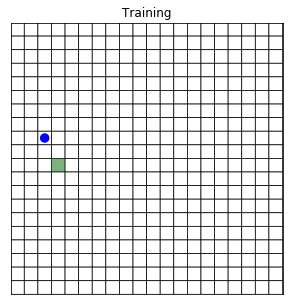

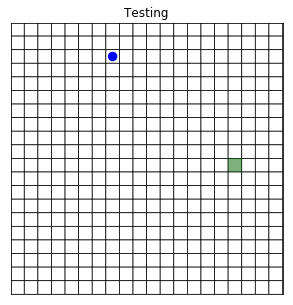

In [2]:
training_reward = (10,3)
testing_reward = (10,16)
env = gw.GridWorld(rows=20,cols=20,rewards = {training_reward:1})
fig = gw.plotWorld(env,current_state=True,scale=0.25, title='Training')
env = gw.GridWorld(rows=20,cols=20,rewards = {testing_reward:1})
fig = gw.plotWorld(env,current_state=True,scale=0.25, title='Testing')

In [71]:
## load in data collected with EC_test_expt.ipynb
MF__ = pickle.load(open('../Blake Meeting/simple_network/MF__.p', 'rb'))
MFEC = pickle.load(open('../Blake Meeting/simple_network/MFEC.p','rb'))
fail = pickle.load(open('../Blake Meeting/simple_network/MF_ECfail.p','rb'))

In [72]:
#MFEC['pol_tracking'] = list(np.zeros(2000))+MFEC['pol_tracking']
MFEC['total_reward'] = list(np.zeros(2000))+ MFEC['total_reward']

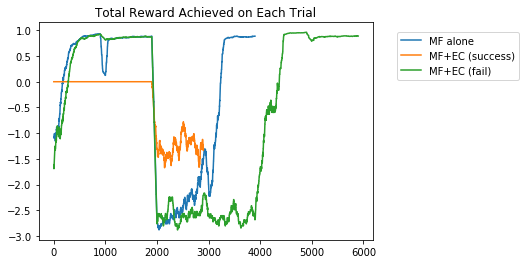

In [73]:
smoothing = 100
plt.plot(gp.running_mean(MF__['total_reward'],smoothing), label='MF alone')
plt.plot(gp.running_mean(MFEC['total_reward'],smoothing), label='MF+EC (success)')
plt.plot(gp.running_mean(fail['total_reward'],smoothing), label='MF+EC (fail)')
plt.legend(bbox_to_anchor = (0.95, 0.98, 0.5, 0), ncol=1)
#plt.xlim([0,4000])
plt.title('Total Reward Achieved on Each Trial')
plt.show()

### How quickly converge on the optimal policy? 

0 0.5
1 1.650644190346661e-40
2 0.5
3 1.650644190346661e-40
4 1.650644190346661e-40
5 1.650644190346661e-40


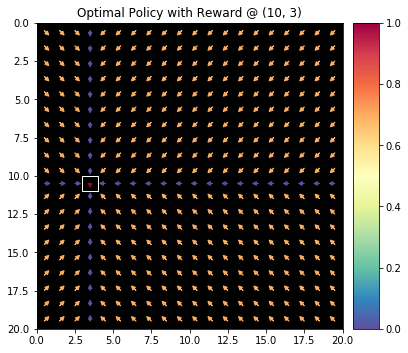

0 0.5
1 1.650644190346661e-40
2 0.5
3 1.650644190346661e-40
4 1.650644190346661e-40
5 1.650644190346661e-40


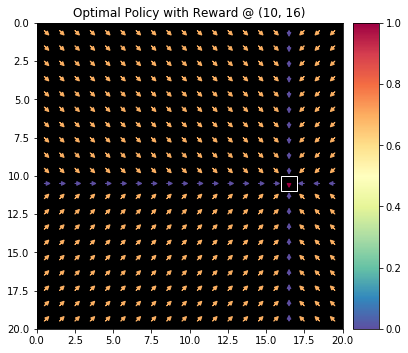

In [35]:
reload(gp)
opt_training = optimal_policy(training_reward)
opt_testing = optimal_policy(testing_reward)
gp.plot_optimal(env,opt_training, rwds=[training_reward],title=f"Optimal Policy with Reward @ {training_reward}" )
gp.plot_optimal(env,opt_testing, rwds=[testing_reward],title=f"Optimal Policy with Reward @ {testing_reward}" )

#### Model Free Alone
Measuring KLD(model_free_policy, optimal_policy)

In [74]:
#MF_kld, MF_kld_avg = calculate_kld(MF__['pol_tracking'],opt_training,opt_testing)
EC_s_kld, EC_s_avg = calculate_kld(MFEC['pol_tracking'],opt_training,opt_testing)
#EC_f_kld, EC_f_avg = calculate_kld(fail['pol_tracking'],opt_training,opt_testing)

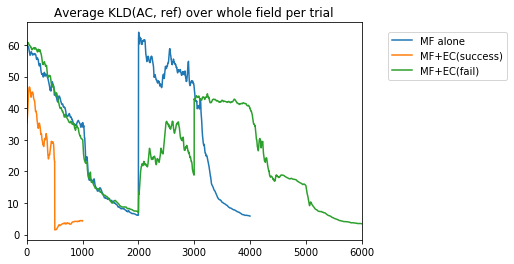

In [60]:
plt.plot(MF_kld_avg,label='MF alone')
plt.plot(EC_s_avg,label='MF+EC(success)')
plt.plot(EC_f_avg,label='MF+EC(fail)')
plt.legend(bbox_to_anchor = (0.95, 0.98, 0.5, 0), ncol=1)
plt.xlim([0,6000])
plt.title('Average KLD(AC, ref) over whole field per trial')
plt.show()

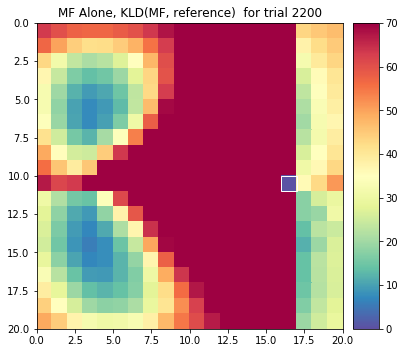

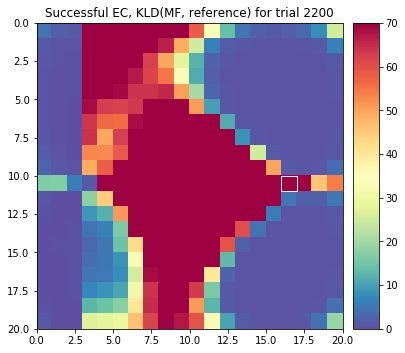

In [75]:
index = 2200
bins =2200 
gp.plot_valmap(env, MF_kld[index],v_range=[0,70], title=f'MF Alone, KLD(MF, reference)  for trial {index}')
gp.plot_valmap(env, EC_s_kld[index-2000],v_range=[0,70], title=f'Successful EC, KLD(MF, reference) for trial {index}')
#gp.plot_valmap(env, EC_f_kld[index],v_range=[0,70], title=f'Failed EC, KLD(MF, reference) for trial {index}')

#data = []
#data1 = []
#for i in range(0,4000,500):
#    print(i)
#    data.append(MF_kld[i].flatten())
#    data1.append(EC_s_kld[i].flatten())
#plt.violinplot(data)
#plt.violinplot(data1)

In [10]:
# calculate KLD (episodic_policies, reference)
ECmem_s_kld, ECmem_s_avg = calculate_kld(MFEC['ec_tracking'],opt_training,opt_testing)
ECmem_f_kld, ECmem_f_avg = calculate_kld(fail['ec_tracking'],opt_training,opt_testing)

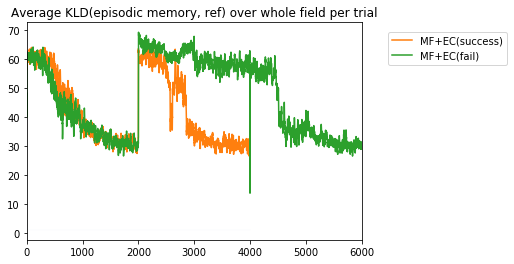

In [11]:
plt.plot(np.ones(len(MF_kld)), alpha=0.01)
plt.plot(ECmem_s_avg,label='MF+EC(success)')
plt.plot(ECmem_f_avg,label='MF+EC(fail)')
plt.legend(bbox_to_anchor = (0.95, 0.98, 0.5, 0), ncol=1)
plt.xlim([0,6000])
plt.title('Average KLD(episodic memory, ref) over whole field per trial')
plt.show()

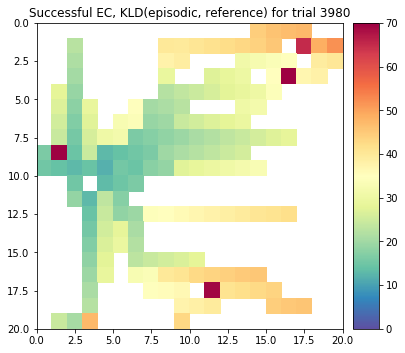

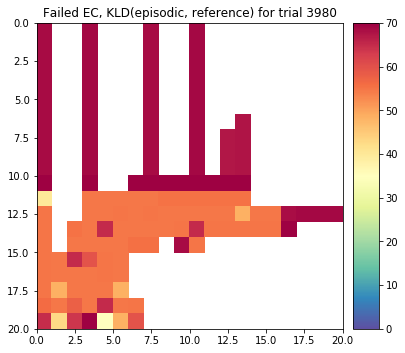

In [76]:
index = 3980
gp.plot_valmap(env, ECmem_s_kld[index],v_range=[0,70], title=f'Successful EC, KLD(episodic, reference) for trial {index}')
gp.plot_valmap(env, ECmem_f_kld[index],v_range=[0,70], title=f'Failed EC, KLD(episodic, reference) for trial {index}')


### Cosine Similarity instead of KLD

In [13]:
from scipy import spatial 

def calculate_cosine_sim(policy1, policy2, **kwargs):
    assert len(policy1) == len(policy2)

    cos_average = []
    cos_holder = []
    
    for i in range(0, len(policy1)):
        cos = np.zeros(policy1[0].shape)

        for j in range(cos.shape[0]):

            for k in range(cos.shape[1]):
                x = policy1[i][j,k].tolist()
                y = policy2[i][j,k].tolist()
                if sum(x)==0:
                    cos[j,k] = np.nan
                else:
                    cos[j,k] = 1 - spatial.distance.cosine(x,y)
        cos_average.append(np.nanmean(cos))
        cos_holder.append(cos)
    return cos_holder, cos_average

In [14]:
cos_sim_s, cossimavg_s = calculate_cosine_sim(MFEC['pol_tracking'], MFEC['ec_tracking'])
cos_sim_f, cossimavg_f = calculate_cosine_sim(fail['pol_tracking'], fail['ec_tracking'])

/home/annik/.local/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


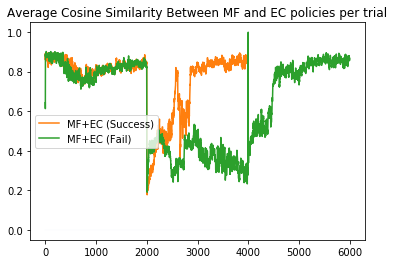

In [15]:
plt.plot(np.zeros(len(cossimavg_s)), alpha=0.01)
plt.plot(cossimavg_s, label="MF+EC (Success)")
plt.plot(cossimavg_f, label="MF+EC (Fail)")
plt.title('Average Cosine Similarity Between MF and EC policies per trial')
plt.legend(loc=0)
plt.show()

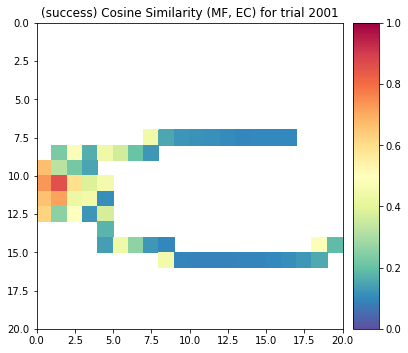

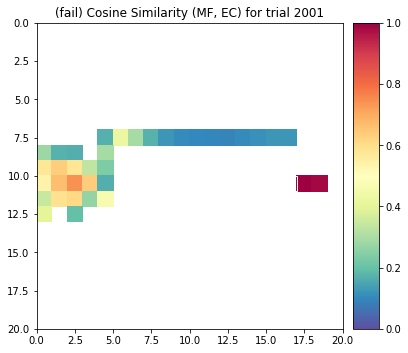

In [19]:
index = 2001
gp.plot_valmap(env, cos_sim_s[index], title=f'(success) Cosine Similarity (MF, EC) for trial {index}')
gp.plot_valmap(env, cos_sim_f[index], title=f'(fail) Cosine Similarity (MF, EC) for trial {index}')